# Analysis of the US Homicide Reports 1980 - 2014

The data used in this project is a courtesy of the Murder Accountability Project, which represents the most complete database of homicides in the United States currently available. This dataset contains murders from the FBI's Supplementary Homicide Report as well as from the Freedom of Information Act's data on more than 22,000 homicides. 
It is an interesting dataset to study as it includes the sex, age, race of both the victims and the perpetrators, the location (city and state) of the crime, in addition to the type of weapon used, and the relationship between the victim and the murderer. 
Some fascinating and insightful discoveries can be extracted from this data. 
In this notebook, we will dive into a visalization of the gruesome American homicide scene.

The dataset contains 638,454 cases (24 columns).


## The needed libraries

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb


## Loading the data

In [174]:
homicide_reports = 'us_homicides_db.csv'
df = pd.read_csv(homicide_reports)



C:\Users\Salma\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial data preparation
1. I will drop some columns that are unnecessary to my analysis (like the Record ID, Agency Code, Agency Name, Agency Type, Incident, etc.).

In [175]:
df = df.drop(columns=['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 
                      'Incident', 'Record Source', 'Perpetrator Count', 'Victim Count'])

2. The column 'Perpetrator Age' has mixed types, so I convert it to integers to be able to work with it.


In [176]:
df['Perpetrator Age'] = pd.to_numeric(df['Perpetrator Age'], errors='coerce')

3. The 'Victim Age' column contains some 0 values: this could either mean that the victim age is unknown or a mistake or that the victim is actually a baby (under 1 yo). We will assume here that the victim is a baby.

4. The 'Perpetrator Age' column contains some 0 values as well. We will assume that these are unknown.

5. A lot of the cases are unsolved and so there are some perpetrator unknown values in the data.


## Global view on the data

The homicides can be divided into 'solved' and 'unsolved' ones:

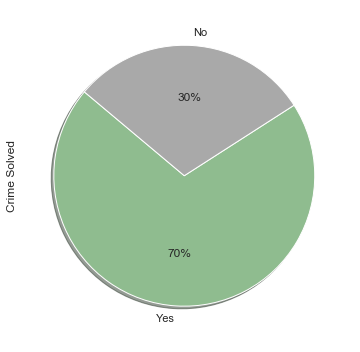

In [177]:
df['Crime Solved'].value_counts().plot.pie(autopct='%1.0f%%', figsize=(6,6), 
                                           colors = ['darkseagreen', 'darkgray'],  shadow=True, startangle=140)

The dataset presents two types of homicides:

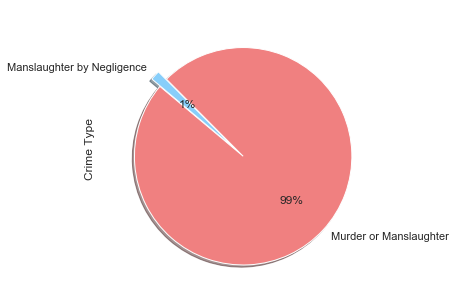

In [178]:
crime_type_count = df['Crime Type'].value_counts()
#print(crime_type_count)
crime_type_count.plot.pie(explode = (0.1, 0), colors = ['lightcoral', 'lightskyblue'], 
                                         autopct='%1.0f%%', figsize=(5,5), shadow=True, startangle=140)

In the following analysis, I chose to focus on the 'Murder or Slaughter' category. As such, I will get rid of 'Manslaughter by Negligence' entries. 

It is worth mentioning the following definitions before we go on:
- Homicide = the killing of one person by another
- Murder = a homicide committed with 'malice aforethought' 
- Manslaughter is considered to be a less severe crime than murder. It could be voluntary (killing under extreme provocation for example) or involuntary (due to acts of negligence/recklessness)

In [179]:
murder=df[df['Crime Type']=='Murder or Manslaughter']
print('By doing so, we only dropped 1% of the data, as we can see from the previous pie chart.')

By doing so, we only dropped 1% of the data, as we can see from the previous pie chart.


Let's look at the evolution of the murder count throughout the years.

AxesSubplot(0.125,0.125;0.775x0.755)


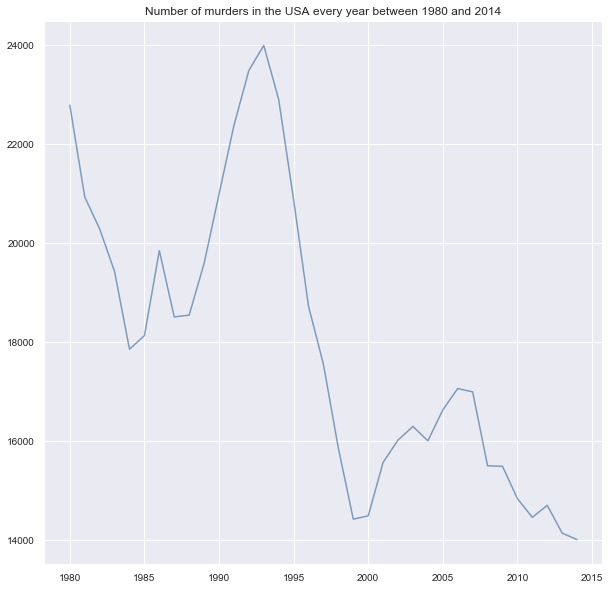

In [180]:
year = murder['Year']
count_years = year.value_counts()
years = count_years.sort_index(axis=0, ascending=False)
print(years.plot(kind='line', fontsize=10, color=(0.2, 0.4, 0.6, 0.6),
  figsize=(10, 10), title='Number of murders in the USA every year between 1980 and 2014'))

In [181]:
year_min = murder['Year'].value_counts().index[34]
total_year_min = murder['Year'].value_counts().min()
print('The least murderous year was', year_min, 'with a total of', total_year_min, 'murders')
year_max = murder['Year'].value_counts().index[0]
total_year_max = murder['Year'].value_counts().max()
print('The most murderous year was', year_max,' with a total of', total_year_max , 'murders')

The least murderous year was 2014 with a total of 14014 murders
The most murderous year was 1993  with a total of 23991 murders


Let's visualize the murder count per US state between 1980 and 2014:

AxesSubplot(0.125,0.125;0.775x0.755)


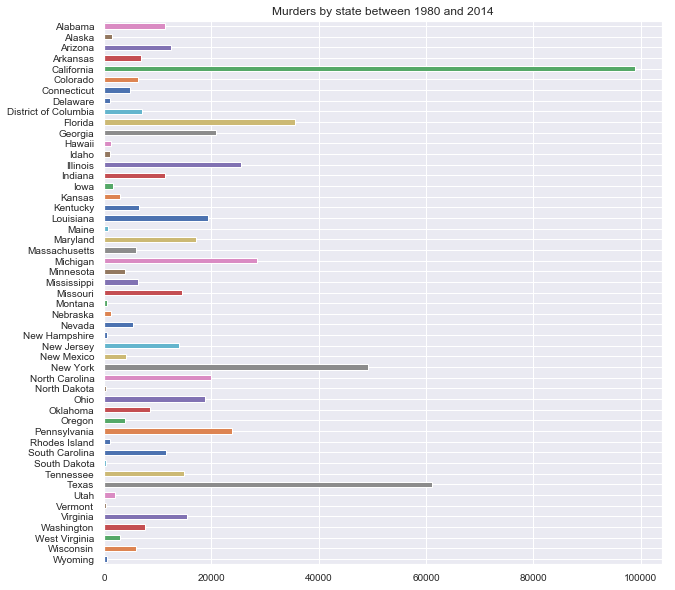

In [182]:
state = murder['State']
count_states = state.value_counts()
states = count_states.sort_index(axis=0, ascending=False)
print(states.plot(kind='barh', fontsize=10,  width=0.5,  figsize=(10, 10), title='Murders by state between 1980 and 2014'))


In [183]:
state_max = murder['State'].value_counts().index[0]
total_state_max = murder['State'].value_counts().max()
state_min = murder['State'].value_counts().index[50]
total_state_min = murder['State'].value_counts().min()

print('The state with the highest number of murders was', state_max,'with a total of', total_state_max, 'murders')
print('The state with the lowest number of murders was', state_min,'with a total of', total_state_min, 'murders')
print('The top 3 most dangerous states in terms of murders are\n', murder['State'].value_counts().nlargest(3))

The state with the highest number of murders was California with a total of 98994 murders
The state with the lowest number of murders was North Dakota with a total of 303 murders
The top 3 most dangerous states in terms of murders are
 California    98994
Texas         61087
New York      49222
Name: State, dtype: int64


## However, once we normalize these total numbers of homicides per state using its population size (the plot that follows shows this), we notice that California, for instance, only has that large number of homicides due to the fact that it is the state with the most people in the USA, followed by Texas, but once we normalize it, we see that California is quite safe actually. The most dangerous state seems to be the District of Columbia where numerous homicides are committed compared to its population estimate. The homicide rates per citizens in Louisiana for example is actually much higher than inTexas.

We will normalize this using the population estimate (from July 2017) for each state


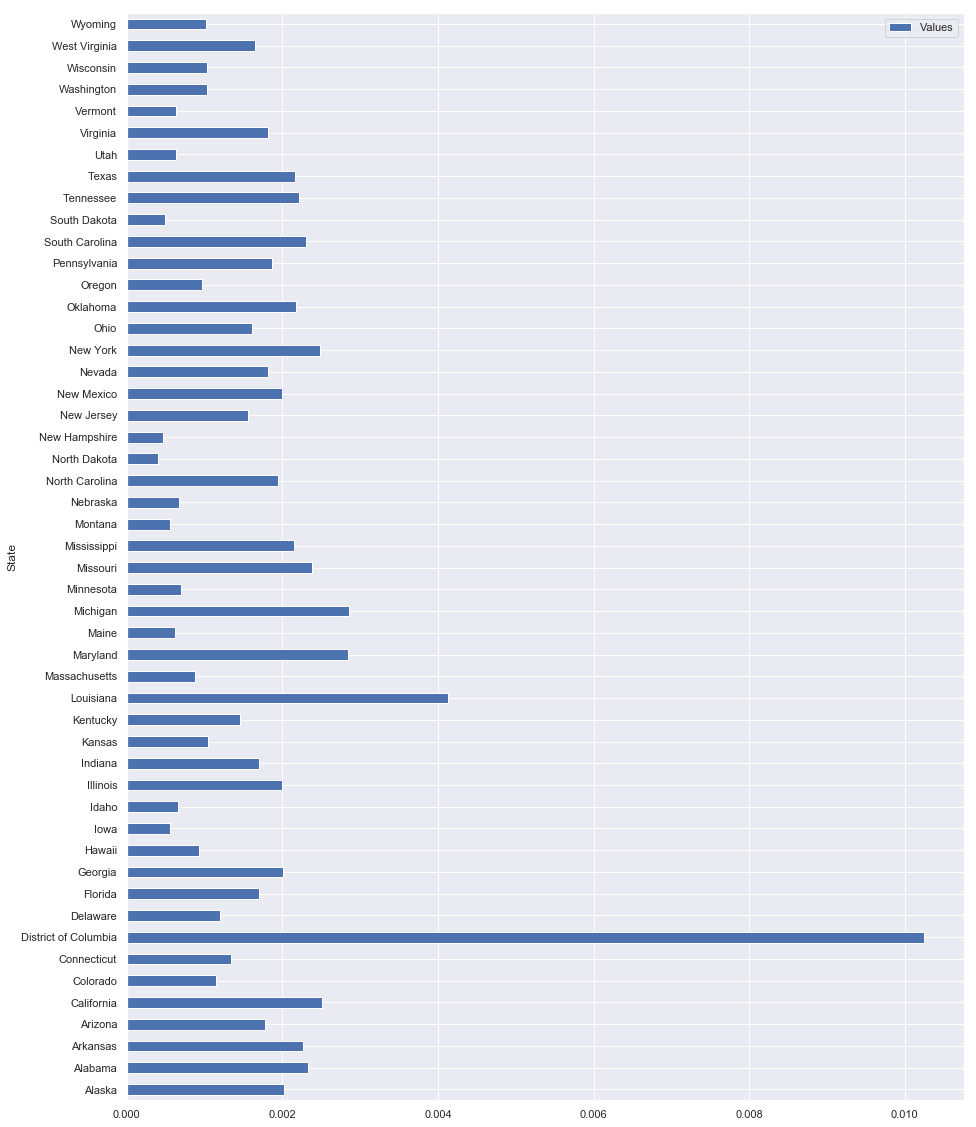

In [184]:
print('We will normalize this using the population estimate (from July 2017) for each state')
pop = pd.read_csv('US_states_population.csv')
pop['Population estimate, July 1, 2017[4]'] = pop['Population estimate, July 1, 2017[4]'].map(lambda x: x.replace(',',''))


state = murder['State']
count_states = state.value_counts()

state_list = []
val_list = []
normalized =  pd.DataFrame()


for state1 in murder['State'].unique():
    for state2 in pop['State or territory']:
        if(state1 == state2):
            state_list.append(state1)
            popnum = pop[pop['State or territory'] == state1]['Population estimate, July 1, 2017[4]']
            num = int(popnum.values[0])
            val = count_states[state1]/num
            val_list.append(val)
            
normalized = normalized.assign(State = state_list)
normalized = normalized.assign(Values = val_list)
normalized = normalized.set_index('State')
            
#plt.figure(figsize=(15,15))
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
normalized.plot(kind='barh', ax = ax)
plt.show()    


## Now, let's start digging a little deeper 

In [186]:
print(murder['Victim Age'].max())

998


This is most probably just a mistake so we can disregard it. 

In [187]:
wrong = murder[murder['Victim Age']==998]
print('There are actually', len(wrong), 'entries that have 998 as the victim age, we will get rid of them as they will affect our future data manipulations. They, luckily, only represent',float(len(wrong)/len(murder))*100, '% of the data')


There are actually 966 entries that have 998 as the victim age, we will get rid of them as they will affect our future data manipulations. They, luckily, only represent 0.1534946245101996 % of the data


In [188]:
murder = murder[murder['Victim Age']!=998]

Let's look at <font color='red'>the ages of the victims</font>:

C:\Users\Salma\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


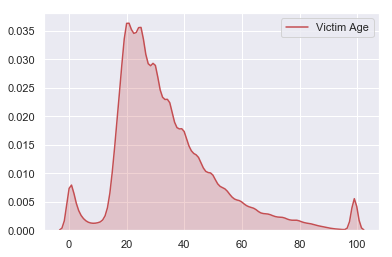

In [189]:
sb.kdeplot(murder['Victim Age'], shade=True, color="r")

We notice two unexpected peaks: 
1. 0-8 years old
2. 97-99 years old

It is quite sad and shocking to see that toddlers and young kids are homicide victims. As for the peak around 99 year olds, it is unlikely that killers are targeting 99 year olds specifically and could be due to the fact that while entering the cases into the database, people who are more than 99 were just included into this category too.


In [190]:
print('The average age of the victims is:', murder['Victim Age'].median())
print('The most common victim age is:', murder['Victim Age'].mode()[0])

#I don't want to drop the rows with Perp age 0 because these might be just unknown 
#and could be insightful in terms of the other columns.
#So I keep them but disregard them for this by only going for age>0 (if I don't, they are so numerous that I get mode=0) 
print('On the other hand, the most occurring perpetrator age is:', murder[murder['Perpetrator Age']>0]['Perpetrator Age'].mode()[0])

The average age of the victims is: 30.0
The most common victim age is: 22
On the other hand, the most occurring perpetrator age is: 20.0


White                            311140
Black                            297124
Asian/Pacific Islander             9774
Unknown                            5911
Native American/Alaska Native      4423
Name: Victim Race, dtype: int64


Text(0, 0.5, '')

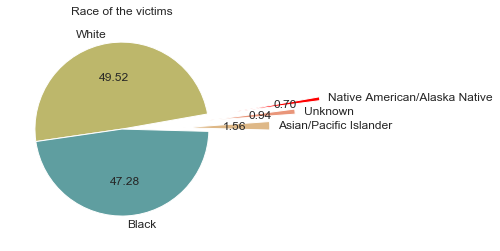

In [191]:
race = murder['Victim Race'] 
count_race = race.value_counts()
print(count_race)
ax = count_race.plot(kind = 'pie',
                              title = 'Race of the victims',
                              startangle = 10,
                              autopct='%.2f',
                              fontsize = 12,
                              colors=['darkkhaki', 'cadetblue', 'burlywood', 'darksalmon','red'],
                              explode=(0, 0, 0.7, 1, 1.3))
ax.set_ylabel('')



Let's look at <font color='red'>the sex of the victims and perpetrators</font>:

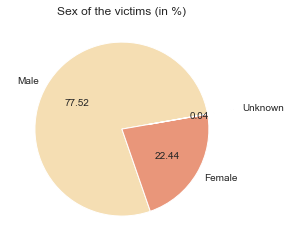

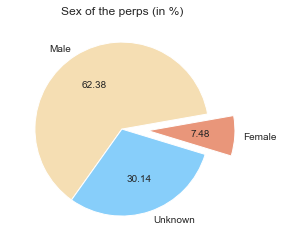

In [192]:
victim_sex =  murder['Victim Sex'].value_counts()
ax = victim_sex.plot(kind = 'pie',
                              title = 'Sex of the victims (in %)',
                              startangle = 10,
                              explode = (0, 0, 0.3),
                              colors = ['wheat', 'darksalmon', 'slateblue'],
                              autopct='%.2f',fontsize=10)
ax.set_ylabel('')
plt.show()

perp_sex =  murder['Perpetrator Sex'].value_counts()
ax = perp_sex.plot(kind = 'pie',
                              title = 'Sex of the perps (in %)',
                              startangle = 10,
                              explode = (0, 0, 0.3),
                              colors = ['wheat', 'lightskyblue', 'darksalmon'],
                              autopct='%.2f',fontsize=10)
ax.set_ylabel('')
plt.show()

We can actually look at the number of murders committed by a female perp against a female victim vs. a male victim, as well as the number of murders committed by a male perp. against a female victim vs. a male victim.


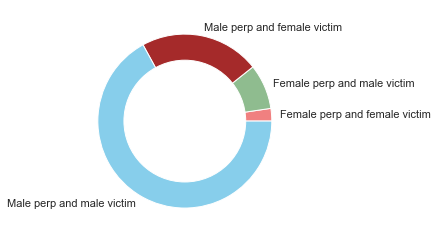

In [193]:
f_f = murder[murder['Perpetrator Sex'] == 'Female']
f_f = f_f[f_f['Victim Sex'] == 'Female']

f_m = murder[murder['Perpetrator Sex'] == 'Female']
f_m = f_m[f_m['Victim Sex'] == 'Male']

m_f =  murder[murder['Perpetrator Sex'] == 'Male']
m_f = m_f[m_f['Victim Sex'] == 'Female']

m_m =  murder[murder['Perpetrator Sex'] == 'Male']
m_m = m_m[m_m['Victim Sex'] == 'Male']

#Will attempt to make this into a donut chart
names='Female perp and female victim', 'Female perp and male victim', 'Male perp and female victim', 'Male perp and male victim',
size=[len(f_f),len(f_m),len(m_f),len(m_m)]
 
#Center circle definition
my_circle=plt.Circle( (0,0), 0.7, color='white')

#Plotting
plt.pie(size, labels=names, colors=['lightcoral','darkseagreen','brown','skyblue'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()



Let's look at <font color='red'>the weapons</font>:

In [194]:
print('The list of weapons used in these murders:')
print(murder['Weapon'].value_counts())
print('As we can see, the most popular weapon is the',df['Weapon'].value_counts().index[0].lower())

The list of weapons used in these murders:
Handgun          313636
Knife             94739
Blunt Object      66566
Firearm           46397
Unknown           31192
Shotgun           29960
Rifle             22525
Strangulation      8091
Fire               5937
Suffocation        3766
Gun                2163
Drugs              1277
Drowning            992
Explosives          519
Poison              432
Fall                180
Name: Weapon, dtype: int64
As we can see, the most popular weapon is the handgun


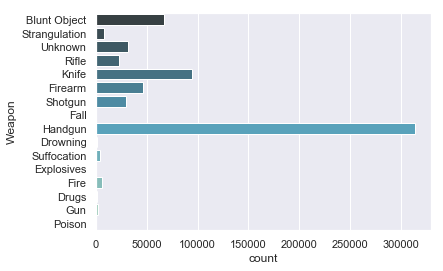

In [195]:
sb.set(style="darkgrid")
sb.countplot(y="Weapon",data=murder, palette="GnBu_d");

Some of these weapons fall into the firearm category but are separated in the data: rifles, handguns, shotguns all fall into the 'firearm' category. There is a lack of specificity in the data. I will thus combine them into one 'firearm' category.

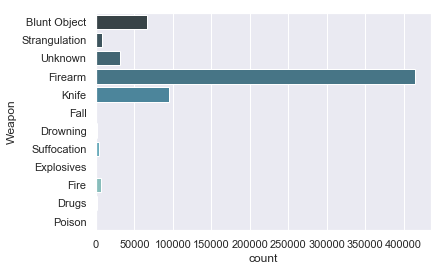

In [196]:
murder_guns_combined = murder
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Handgun', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Rifle', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Shotgun', 'Weapon'] = 'Firearm'
murder_guns_combined.loc[murder_guns_combined['Weapon']=='Gun', 'Weapon'] = 'Firearm'

#sb.countplot(y="Weapon",data=murder_guns_combined, palette="GnBu_d");
sb.countplot(y="Weapon",data=murder, palette="GnBu_d");


We can also get a global idea of the age groups for different victims depending on their relationships with the perpetrators.

C:\Users\Salma\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Salma\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\Salma\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


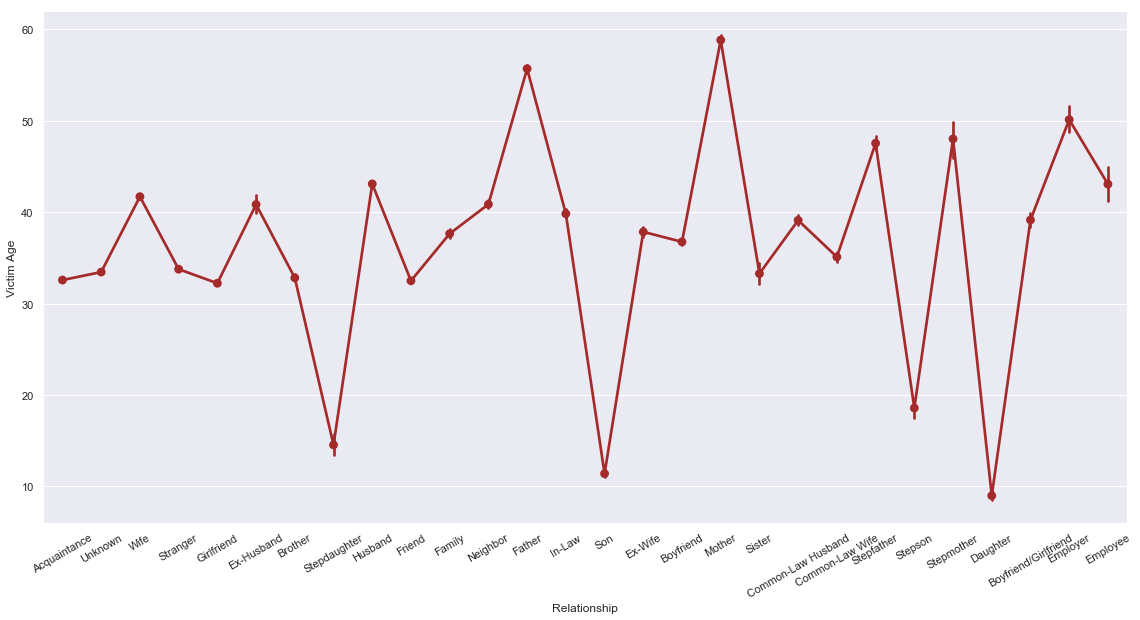

In [197]:
g = sb.factorplot(x='Relationship', y='Victim Age', data=murder, kind="point", color='brown', size=8, aspect=2)
g.set_xticklabels(rotation=30)

## Now, let's dig even deeper into our data by exploring some more complex lines of inquiry (Who are women/men more likely to kill? Which weapon is the most used by a certain perpetrator?)

First of all, we take a closer look at the weapons that are most often used based on the gender of the perpetrator. 
In the following part, I set a threshold of 1%, such that the weapons that are used in less than 1% of the cases are combined into the 'Other' category.

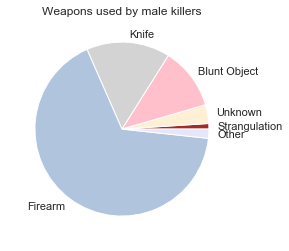

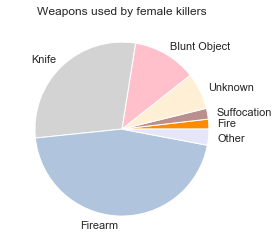

In [198]:
threshold=0.01
weapon_M= murder[murder['Perpetrator Sex']=='Male']['Weapon'].value_counts(normalize=True).sort_values()
weapon_F= murder[murder['Perpetrator Sex']=='Female']['Weapon'].value_counts(normalize=True).sort_values()
weapon_M['Other']=weapon_M[weapon_M<threshold].sum()
weapon_F['Other']=weapon_F[weapon_F<threshold].sum()

plt.figure()
plt.pie(weapon_M[weapon_M>threshold].values,labels=weapon_M[weapon_M>threshold].index, 
        colors=['brown', 'papayawhip', 'pink', 'lightgrey', 'lightsteelblue', 'lavender', 'lavender'])
plt.title('Weapons used by male killers')
plt.show()

plt.figure()
plt.pie(weapon_F[weapon_F>threshold].values,labels=weapon_F[weapon_F>threshold].index,
        colors=['darkorange', 'rosybrown', 'papayawhip', 'pink', 'lightgrey', 'lightsteelblue', 'lavender'])
plt.title('Weapons used by female killers')
plt.show()

Some observations:
- Most perpetrators (regardless of their gender) use guns as weapons of choice, followed by knives and blunt objects. 
- Males go for guns more often than women.
- Women opt for guns in less than half of the cases. 
- Since men use firearms for so much of their killing, and women use them much less frequently, it turns out that women tend to opt for every other weapon more than men. Women use a wider range of weapons.


Now, we will look closer into the victim-perp relationships.

The following heatmap shows the relationship between how the victim is related to the perp and the killer's gender.

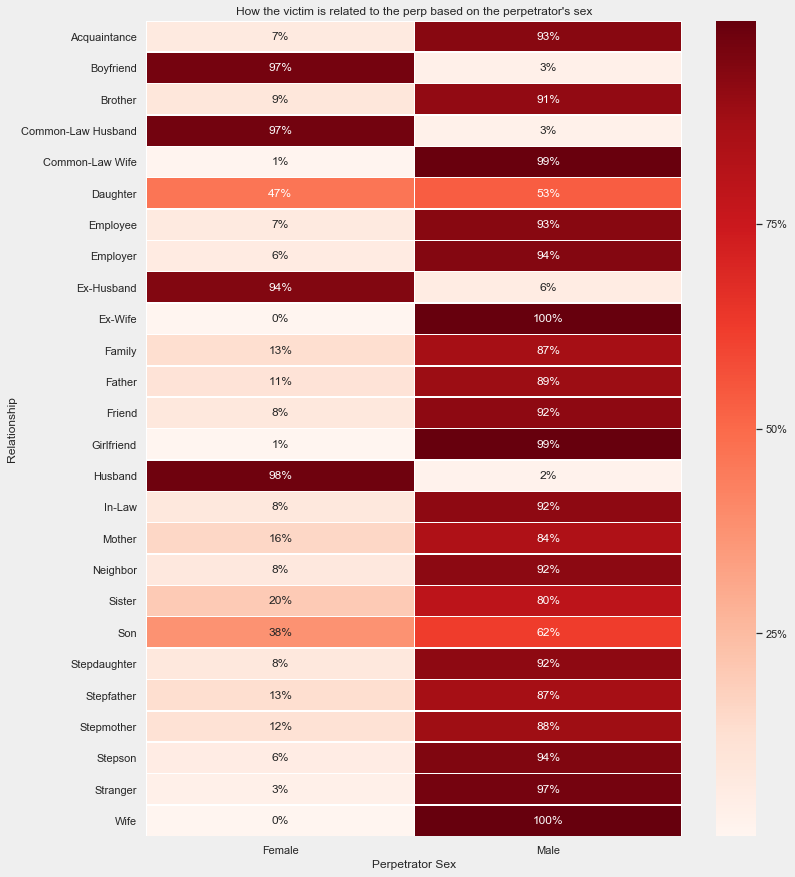

In [199]:
plt.figure(figsize=(12,15),facecolor='#efefef')
known = murder[murder['Perpetrator Sex'] != 'Unknown']
known = known[known['Relationship'] != 'Unknown']
known = known[known['Relationship'] != 'Boyfriend/Girlfriend']
ax = sb.heatmap(pd.crosstab(known['Relationship'], known['Perpetrator Sex']).apply(lambda r: r/r.sum(), axis=1), annot=True, fmt=".0%", linewidths=.5,cmap='Reds')
ax.set_title('How the victim is related to the perp based on the perpetrator\'s sex')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, .25, .50, .75, 1])
cbar.set_ticklabels(['0%', '25%', '50%',  '75%', '100%'])


C:\Users\Salma\Anaconda3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"
C:\Users\Salma\Anaconda3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


Text(0, 0.5, '')

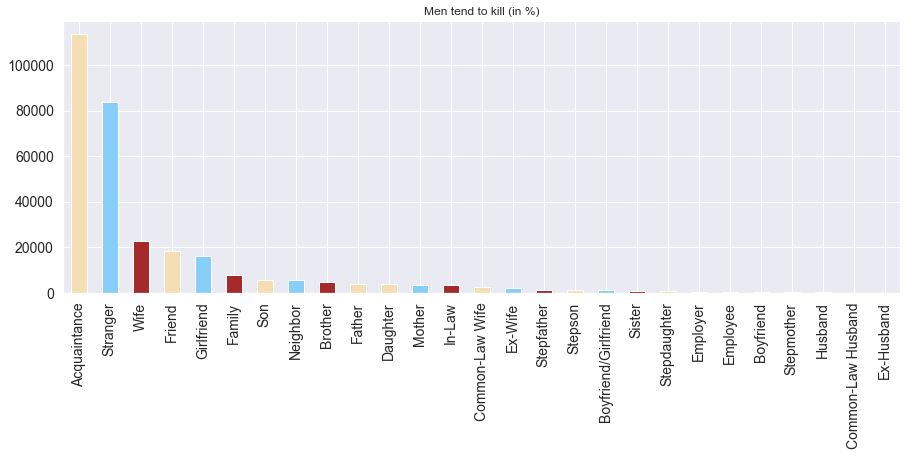

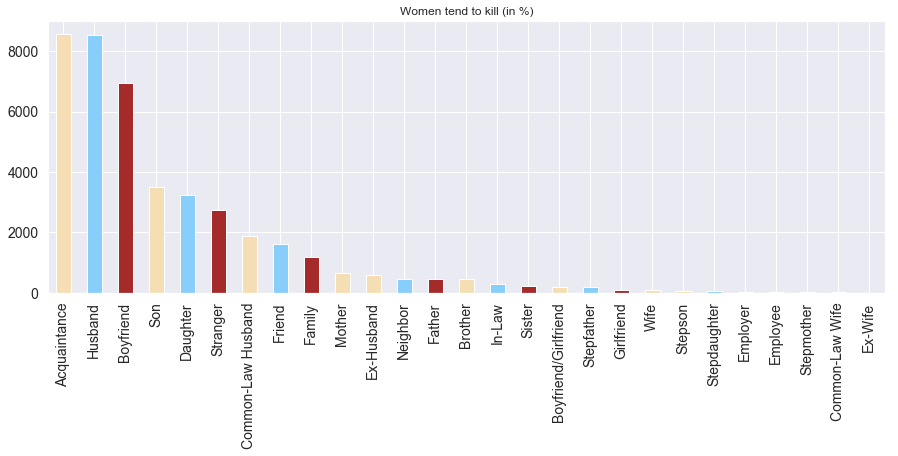

In [200]:
male_killer = murder[murder['Perpetrator Sex'] == 'Male']
male_killer = male_killer[male_killer['Relationship'] != 'Unknown']
menkill =  male_killer['Relationship'].value_counts()
plt.figure(figsize=(15,5))
ax = menkill.plot(kind = 'bar',
                              title = 'Men tend to kill (in %)',
                              colors = ['wheat', 'lightskyblue', 'brown', 'wheat', 'lightskyblue', 'brown', 'wheat', 'lightskyblue', 'brown'],
                              fontsize=14)
ax.set_ylabel('')



female_killer = murder[murder['Perpetrator Sex'] == 'Female']
female_killer = female_killer[female_killer['Relationship'] != 'Unknown']
womenkill =  female_killer['Relationship'].value_counts()
plt.figure(figsize=(15,5))
ax = womenkill.plot(kind = 'bar',
                              title = 'Women tend to kill (in %)',
                              colors = ['wheat', 'lightskyblue', 'brown', 'wheat', 'lightskyblue', 'brown', 'wheat', 'lightskyblue', 'brown'],
                              fontsize=14)
ax.set_ylabel('')

Men, as we can see, seem to attack people with a not-so-close connection to them. Men murderers have killed from 2 majority groups: acquaintances, complete strangers, and then on a lesser scale wives.
On the other hand, women have mostly attacked close people: acquaintance, husbands and boyfriends. 
Women are way more likely to attack their partners.

Finally, we can now investigate in more detail some relationships, for instance:

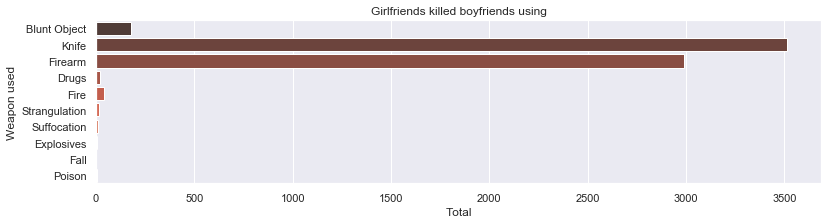

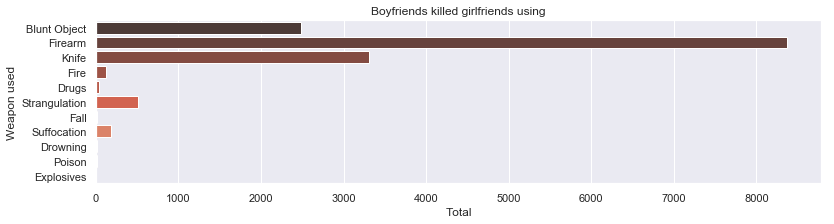

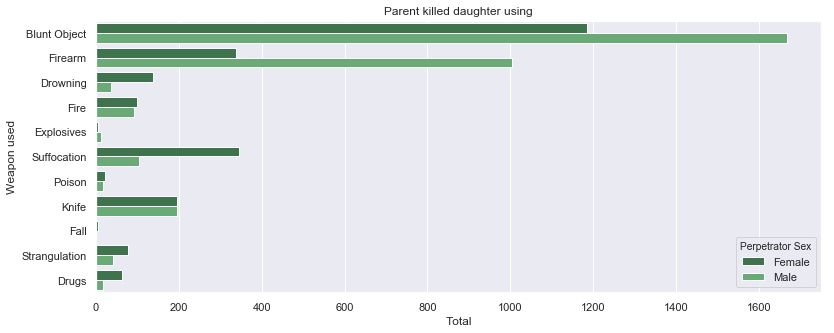

In [201]:
#Girlfriend killed boyfriend
gf_bf = murder[murder['Perpetrator Sex'] == 'Female']
gf_bf = gf_bf[gf_bf['Victim Sex'] == 'Male'] 
gf_bf = gf_bf[gf_bf['Relationship'] == 'Boyfriend'] 
gf_bf = gf_bf[gf_bf['Weapon'] != 'Unknown']

#Boyfriend killed girlfriend
bf_gf = murder[murder['Perpetrator Sex'] == 'Male']
bf_gf = bf_gf[bf_gf['Victim Sex'] == 'Female'] 
bf_gf = bf_gf[bf_gf['Relationship'] == 'Girlfriend'] 
bf_gf = bf_gf[bf_gf['Weapon'] != 'Unknown']

plt.figure(figsize=(13,3))
ax = sb.countplot(y="Weapon",data=gf_bf, palette="OrRd_d");
ax.set_title('Girlfriends killed boyfriends using')
ax.set_ylabel('Weapon used')
ax.set_xlabel('Total')
plt.show()

plt.figure(figsize=(13,3))
ax = sb.countplot(y="Weapon",data=bf_gf, palette="OrRd_d");
ax.set_title('Boyfriends killed girlfriends using')
ax.set_ylabel('Weapon used')
ax.set_xlabel('Total')
plt.show()

parent_daughter = murder[murder['Victim Sex'] == 'Female']
parent_daughter = parent_daughter[parent_daughter['Relationship'] == 'Daughter'] 
parent_daughter = parent_daughter[parent_daughter['Weapon'] != 'Unknown']
parent_daughter = parent_daughter[parent_daughter['Perpetrator Sex'] != 'Unknown']

plt.figure(figsize=(13,5))
ax = sb.countplot(y="Weapon",data=parent_daughter, palette="Greens_d", hue='Perpetrator Sex');
ax.set_title('Parent killed daughter using')
ax.set_ylabel('Weapon used')
ax.set_xlabel('Total')
plt.show()



# Conclusion:
There are so many different ways to look at the same dataset. 
The possibilities are endless, and it is utterly fascinating.
By simply playing around with the data, we could approach this dataset and answer a myriad of questions by looking into the homicides from a gun violence/gun regulations point of view, or approach this from a race/ethnicity angle (preferred weapons, ages, victims per race, etc.), or try to look at which law enforcement agency is the most efficient, and so on.
For the sake of this project, I tried to go for a global exploratory analysis and data visualization, and then tried to focus my efforts towards more specific lines of inquiry.